<h2>Sentiment Analysis and Recommendation System</h2>
<h3> Mt SAC CISB 62 </h3>
<h3>Final Project Fall 2023</h3>
<h3> Alexander Alvarez</h3>

<h2>Introduction</h2>

#### The 'Amazon Fine Food Reviews' from kaggle.The complete datas has about 560,000 reviews, but we can trim the dataset to 20,000 reviews.

The goal is to recommend new products for Reviewer that does reviews often, and using RNN to do an Sentimental Analyst using only the Amazon reviews as the model.

https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import re
import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from nltk.corpus import stopwords
from string import punctuation
# pd.set_option('display.max_colwidth', None)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Importing the data set
df = pd.read_csv('20k_Reviews.csv')
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [4]:
#Information regarding the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      20000 non-null  int64 
 1   ProductId               20000 non-null  object
 2   UserId                  20000 non-null  object
 3   ProfileName             19999 non-null  object
 4   HelpfulnessNumerator    20000 non-null  int64 
 5   HelpfulnessDenominator  20000 non-null  int64 
 6   Score                   20000 non-null  int64 
 7   Time                    20000 non-null  int64 
 8   Summary                 20000 non-null  object
 9   Text                    20000 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.5+ MB


In [5]:
#List of columns
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [6]:
df.shape

(20000, 10)

In [7]:
#Grabing the columns that we need 
df_reviews = df[['ProductId','ProfileName','Score','Text','HelpfulnessNumerator','HelpfulnessDenominator']]

#### Let's display the top 10 reviewers in the list.

In [8]:
#Loading the top 10 Reviewers with the most reviews.
df.pivot_table(columns=['ProfileName'], aggfunc='size').sort_values(ascending=False).head(10)

ProfileName
c2                                            22
Chris                                         17
Carrie, "Formerly &#34;Sister Carrie&#34;"    16
C. F. Hill "CFH"                              15
John                                          14
Gary Peterson                                 14
Dan                                           14
Mike                                          11
Jim                                           11
Jared Castle                                  11
dtype: int64

In [9]:
popular = df[['ProductId','ProfileName']].groupby('ProductId').count().sort_values(['ProfileName'], ascending=False).reset_index()

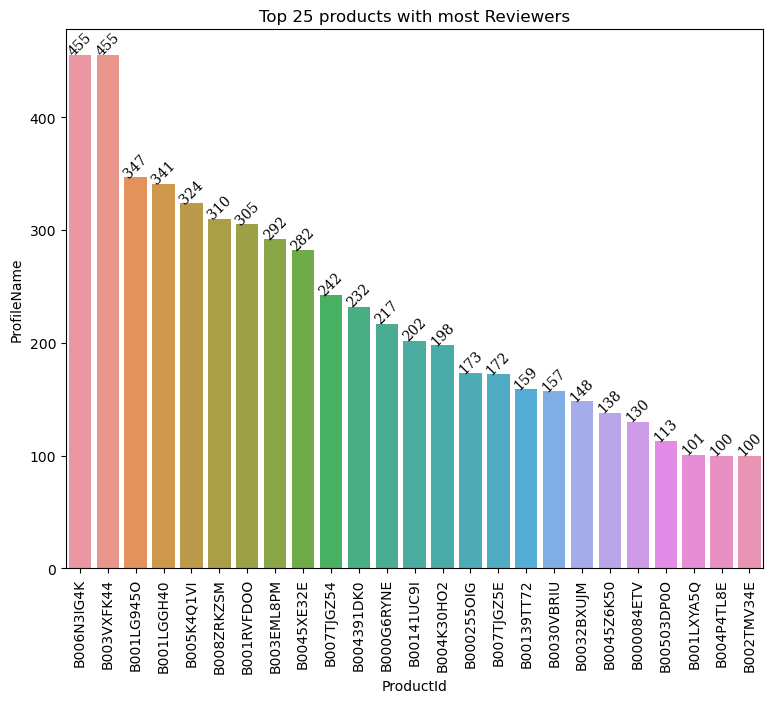

In [10]:
p = popular.sort_values('ProfileName',ascending=False).head(25)
plt.figure(figsize=(9,7))
graph=sns.barplot(x=p.ProductId, y=p.ProfileName, order=p.ProductId)
plt.xticks(rotation=90)
plt.title('Top 25 products with most Reviewers')
plt.ylabel('ProfileName')

i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        popular['ProfileName'][i],ha="center",size="medium",fontfamily="serif",rotation=45)
    i += 1

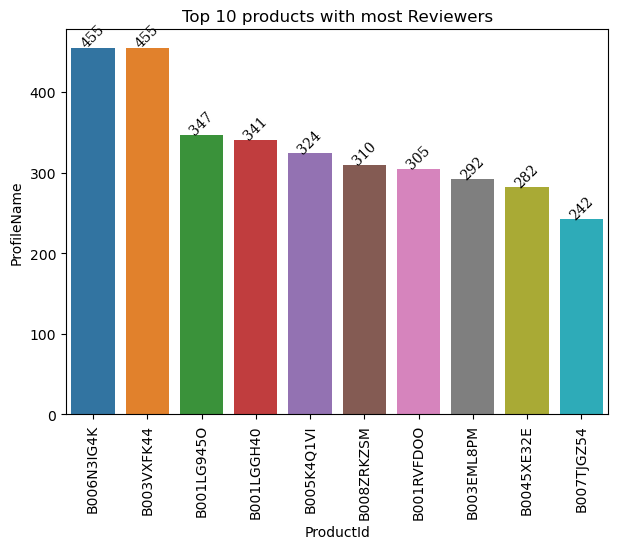

In [11]:
p = popular.sort_values('ProfileName',ascending=False).head(10)
plt.figure(figsize=(7,5))
graph = sns.barplot(x=p.ProductId, y=p.ProfileName, order=p.ProductId)
plt.xticks(rotation=90)
plt.title('Top 10 products with most Reviewers')
plt.ylabel('ProfileName')

i=0
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,
        popular['ProfileName'][i],ha="center",size="medium",fontfamily="serif",rotation=45)
    i += 1

In [12]:
#Filtering all the reviews made by user c2
df_reviews_chris=df_reviews[df_reviews['ProfileName']=='c2']
df_reviews_chris

,ProductId,ProfileName,Score,Text,HelpfulnessNumerator,HelpfulnessDenominator
143,B001GVISJW,c2,5,If you are looking for a less messy version of...,0,0
3587,B004X8TK9W,c2,5,I may be dating myself here a bit but I rememb...,1,1
4993,B000FA398U,c2,5,Try these first for all your seafood soups and...,3,3
6371,B000084EKO,c2,3,I honestly cannot say that I saw any differenc...,0,0
6372,B000084EKA,c2,4,I think 9 Lives does a better job on this vari...,0,0
6373,B000084EKB,c2,4,This version is ground. NOt my current cat's ...,0,0
6374,B000084EKC,c2,5,"According to my cat, this stuff is just great....",1,1
6375,B000084EKD,c2,2,I haven't had a cat yet that liked this one. ...,1,1
6380,B000084EKG,c2,5,This is my cat's favorite one. He just licks ...,2,2
6382,B000084EK8,c2,3,Once or twice a year for a little variety and ...,2,2


<h3>Plotting his percentage of positive views vs negative reviews</h3>

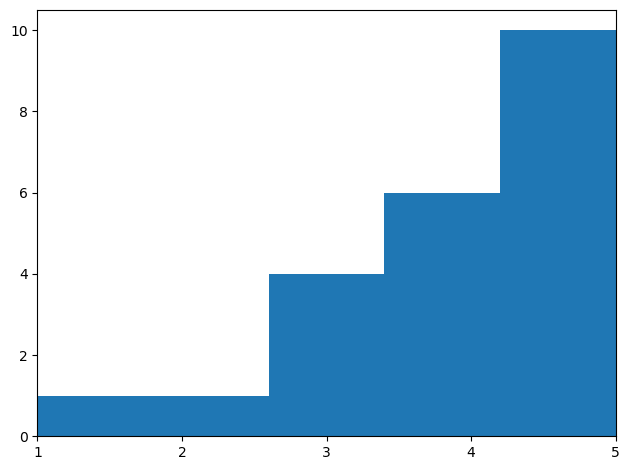

In [13]:
#Plotting C2's percentage of positive views vs negative reviews
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.hist(df_reviews_chris['Score'],bins=5)
plt.xlim([1, 5])
plt.xticks(np.arange(1, 6, 1))
plt.show()

<h3> Plotting the total reviews</h3>

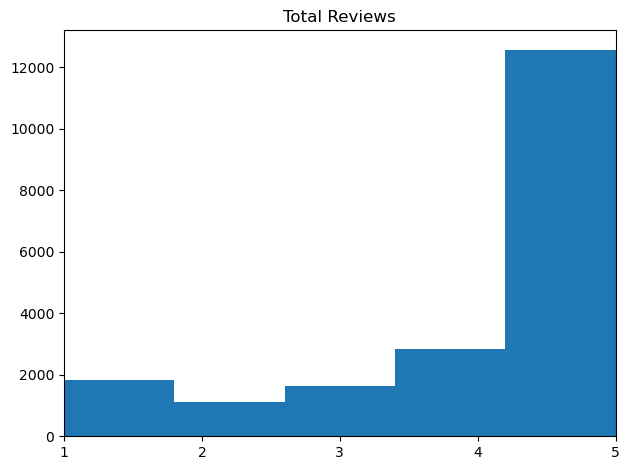

In [14]:
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.hist(df_reviews['Score'],bins=5)
plt.xlim([1, 5])
plt.xticks(np.arange(1, 6, 1))
plt.title('Total Reviews')
plt.show()

#### Let's prepare a histogram of helpfulness rating

In [15]:
df_reviews['Percent'] = (df_reviews['HelpfulnessNumerator'] / df_reviews['HelpfulnessDenominator'])*100
df_reviews['Percent'].fillna(0,inplace=True)

Exploring if the Helpfulness Rating does any impact on the items and reviews.

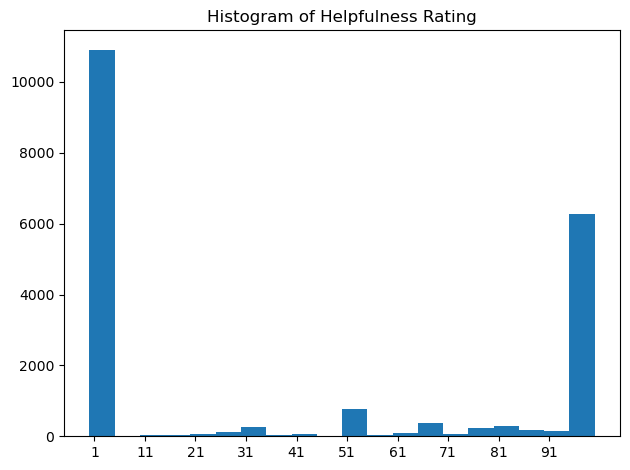

In [16]:
fig, axs = plt.subplots(sharey=True, tight_layout=True)
axs.hist(df_reviews['Percent'],bins=20)
plt.xticks(np.arange(1, 100, 10))
plt.title('Histogram of Helpfulness Rating')
plt.show()

Changing the Score into Postive and Negative Values.

In [17]:
df_reviews['Polarity_Rating'] = df_reviews['Score'].apply(lambda x: 'Positive' if x > 3 else 'Negative')

Seeing the Postive and Negative rations.

<Axes: xlabel='Polarity_Rating', ylabel='count'>

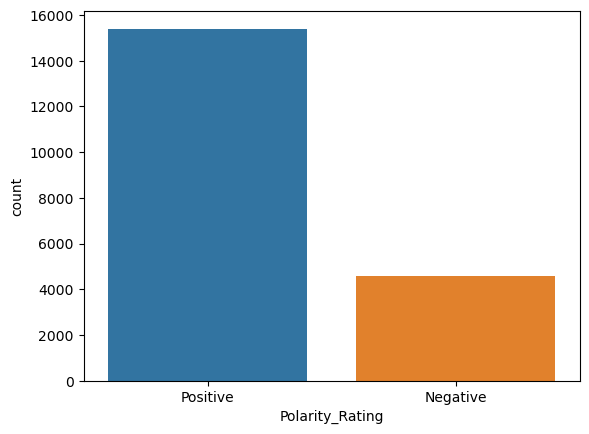

In [18]:
#plotting the ratio of Positive and Negative Reviews
sns.countplot(data = df_reviews, x= 'Polarity_Rating')

<Axes: ylabel='count'>

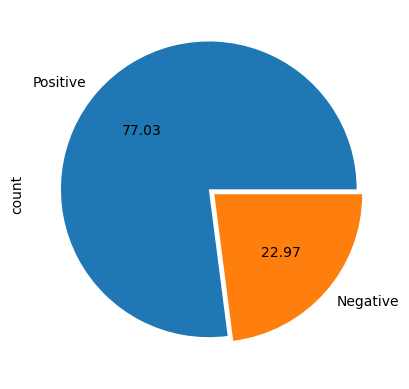

In [19]:
#plotting the ratio of Positive and Negative Reviews in a pie Chart
myexplode = [0.05, 0]
df_reviews['Polarity_Rating'].value_counts().plot(kind="pie",autopct="%.2f",explode=myexplode)

By looking at the data, we can see that there are more Positive reviews than Negative. Thus, let's balance the data so it will have a 50/50 rating.

In [20]:
df_reviews[df_reviews['Polarity_Rating'] == 'Negative'].shape[0]

4593

We can see there is only 4,593 negative reviews, so we will filter out 5,000 positive reviews from the data set

In [21]:
data_Positive = df_reviews[df_reviews['Polarity_Rating'] == 'Positive'][0:5000]
data_Negative = df_reviews[df_reviews['Polarity_Rating'] == 'Negative']

data_Negative_over = data_Negative.sample(8000, replace=True)
df_balance_reviews = pd.concat([data_Positive, data_Negative_over], axis=0)

Downloading stopwords from nltk

In [22]:
#Setting the stop words
english_stops = set(stopwords.words('english'))

Cleaning and splitting the data into Reviews and Review Score.

In [23]:
df = df_balance_reviews
x_data = df['Text']       # Reviews/Input
y_data = df['Polarity_Rating']    # Sentiment/Output

# PRE-PROCESS REVIEW
x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case

# ENCODE SENTIMENT -> 0 & 1
y_data = y_data.replace('Positive', 1)
### simmilarly for y_data
y_data = y_data.replace('Negative', 0)

Splitting the dataset for training

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=101)

Making a function to get the max length for padding

In [25]:
def get_max_length(x_train):
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [26]:
max_length = get_max_length(X_train)
print(max_length)

48


Loading the Tokenizer to convert the words into sequences and then add the padding to make the rows equal lenght.

In [27]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # False becuase we already did it. 
token.fit_on_texts(X_train)
x_train = token.texts_to_sequences(X_train)
x_test = token.texts_to_sequences(X_test)

### this is the code to add the pad to x_train
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')

############# add pad to x_test   ########################### 
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # we need to add 1 because of 0 padding

Building the RNN with LSTM Model. 

In [28]:
# ARCHITECTURE
EMBED_DIM = 3200
LSTM_OUT = 64

#### add the model here:
model = Sequential()

#model.add(Embedding(input_dim=max_length, output_dim=LSTM_OUT,input_length=max_length))
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(units=1, activation='sigmoid'))

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Adding a Checkpoint to save the model.
checkpoint = ModelCheckpoint('models/LSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 3200)          54249600  
                                                                 
 lstm (LSTM)                 (None, 64)                835840    
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 55085505 (210.13 MB)
Trainable params: 55085505 (210.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
history = model.fit(x_train, y_train, epochs=3, batch_size=20, callbacks= [checkpoint],validation_data=(x_test, y_test))

Epoch 1/3
520/520 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.7862
Epoch 1: accuracy improved from -inf to 0.78615, saving model to models/LSTM.h5
520/520 [==============================] - 91s 174ms/step - loss: 0.4591 - accuracy: 0.7862 - val_loss: 0.3586 - val_accuracy: 0.8615
Epoch 2/3
520/520 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9382
Epoch 2: accuracy improved from 0.78615 to 0.93817, saving model to models/LSTM.h5
520/520 [==============================] - 91s 175ms/step - loss: 0.1767 - accuracy: 0.9382 - val_loss: 0.3032 - val_accuracy: 0.8923
Epoch 3/3
520/520 [==============================] - ETA: 0s - loss: 0.0643 - accuracy: 0.9796
Epoch 3: accuracy improved from 0.93817 to 0.97962, saving model to models/LSTM.h5
520/520 [==============================] - 90s 173ms/step - loss: 0.0643 - accuracy: 0.9796 - val_loss: 0.3664 - val_accuracy: 0.8881


Plotting the loss

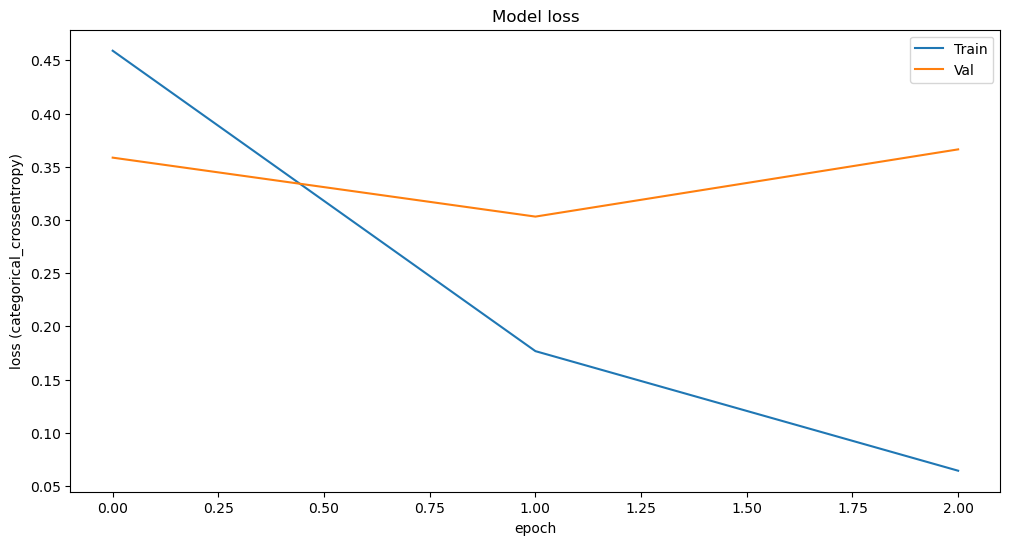

In [31]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')

Plotting the Accuracy

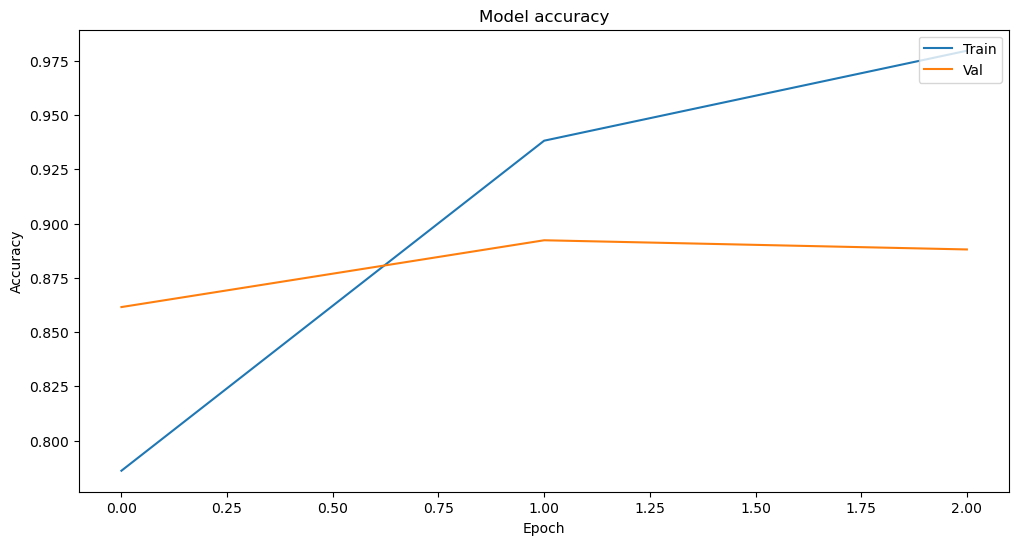

In [32]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['accuracy'][:])
plt.plot(model.history.history['val_accuracy'][:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

Now we can test out the model.

In [33]:
#I grab a random review from the dataframe
value=200
df_reviews.iloc[value]

ProductId                                                        B0028C44Z0
ProfileName                                                             Lou
Score                                                                     2
Text                      Even with small containers, they don't fill th...
HelpfulnessNumerator                                                      0
HelpfulnessDenominator                                                    0
Percent                                                                 0.0
Polarity_Rating                                                    Negative
Name: 200, dtype: object

In [34]:
df_reviews.iloc[value]['Text']

"Even with small containers, they don't fill them up.  These little tins are less than half filled and at the price charged it seems a rip-off. Is there some exotic ingredient as costly as gold contained in those tiny squares?  Or how about the cereal ploy, they were filled at the factory but settled in transport.<br />Can manufacturers be honest in their dealings?"

Cleaning the data before loading it to the model for prediction

In [35]:
review = df_reviews.iloc[value]['Text']

regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]

Tokenized and Encoded the word so it can be loaded into the model for prediction

In [36]:
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
print(tokenize_words)

[[   22   104  1015   788  1181    69    28  2046    95   199   880    32
   3922   256  4850   716  3753   370  5154  1567  1177   696  3349  1119
    791  4521   880  3306  5389   965  2318  1233 14404     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


In [37]:
result = model.predict(tokenize_words)
print(result)
if result >= .50:
    print('Positive')
else:
    print('Negative')

1/1 [==============================] - 0s 147ms/step
[[0.00423851]]
Negative


In [38]:
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import itertools

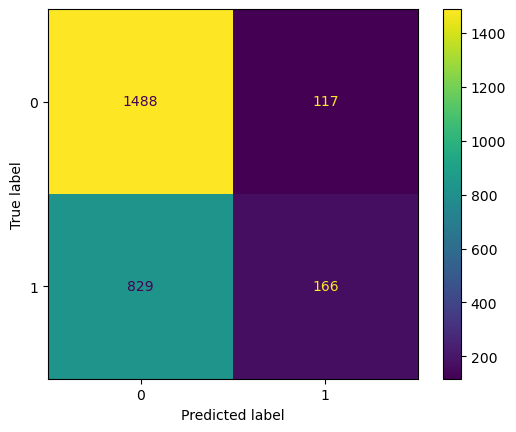

In [39]:
clf = SVC(random_state=0)
clf.fit(x_train, y_train)
SVC(random_state=0)
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test)

<h1>Preparing to train the model for Recommedation.</h1>

The code from Restricted Boltzmann machine model using Tensorflow v1 was taken from CISB62 Week 12

In [40]:
#Making an Unique Numeric ID for all the users
df_reviews['UserID'] = pd.factorize(df_reviews['ProfileName'])[0] + 1

In [42]:
df_reviews[df_reviews['ProfileName'] == 'c2']['UserID'].unique()

array([143])

In [43]:
df_reviews[df_reviews['UserID'] == 143].head()

,ProductId,ProfileName,Score,Text,HelpfulnessNumerator,HelpfulnessDenominator,Percent,Polarity_Rating,UserID
143,B001GVISJW,c2,5,If you are looking for a less messy version of...,0,0,0.0,Positive,143
3587,B004X8TK9W,c2,5,I may be dating myself here a bit but I rememb...,1,1,100.0,Positive,143
4993,B000FA398U,c2,5,Try these first for all your seafood soups and...,3,3,100.0,Positive,143
6371,B000084EKO,c2,3,I honestly cannot say that I saw any differenc...,0,0,0.0,Negative,143
6372,B000084EKA,c2,4,I think 9 Lives does a better job on this vari...,0,0,0.0,Positive,143


In [44]:
#I had to clean the data some more, some review went back and review the same item mulitple times as a follow up.
cleaned = df_reviews.drop_duplicates(subset=['ProductId', 'UserID'], keep='last')

print('Removed Duplicated, Total Reviews {}'.format(cleaned.shape[0]))
print('Total Reviews {}'.format(df_reviews.shape[0]))

Removed Duplicated, Total Reviews 19738
Total Reviews 20000


In [45]:
cleaned.head()

,ProductId,ProfileName,Score,Text,HelpfulnessNumerator,HelpfulnessDenominator,Percent,Polarity_Rating,UserID
0,B001E4KFG0,delmartian,5,I have bought several of the Vitality canned d...,1,1,100.0,Positive,1
1,B00813GRG4,dll pa,1,Product arrived labeled as Jumbo Salted Peanut...,0,0,0.0,Negative,2
2,B000LQOCH0,"Natalia Corres ""Natalia Corres""",4,This is a confection that has been around a fe...,1,1,100.0,Positive,3
3,B000UA0QIQ,Karl,2,If you are looking for the secret ingredient i...,3,3,100.0,Negative,4
4,B006K2ZZ7K,"Michael D. Bigham ""M. Wassir""",5,Great taffy at a great price. There was a wid...,0,0,0.0,Positive,5


In [46]:
user_rating_df = cleaned.pivot(index='UserID', columns='ProductId', values='Score')

In [47]:
user_rating_df.head(5)

ProductId,B00002NCJC,B00002Z754,B00005V3DC,B000084DVR,B000084E1U,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,...,B0093NIWVO,B00959DMWK,B00961CUXO,B0096E5196,B009AVDFCK,B009D668KS,B009HINRX8,B009KP6HBM,B009UOFU20,B009WSNWC4
UserID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Lets normalize it now:

In [48]:
tf.compat.v1.disable_eager_execution()

In [49]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### define your parameters and placeholders

In [50]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)
vb = tf.compat.v1.placeholder("float", [visibleUnits])
hb = tf.compat.v1.placeholder("float", [hiddenUnits])
W = tf.compat.v1.placeholder("float", [visibleUnits, hiddenUnits])

# Process phase 1 of a RBM, use v0, _h0, h0
v0 = tf.compat.v1.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random.uniform(tf.shape(input=_h0))))

#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(input=_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

#Learning rate
alpha = 1.0

w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

CD = (w_pos_grad - w_neg_grad) / tf.compat.v1.to_float(tf.shape(v0)[0])

update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

err = v0 - v1
err_sum = tf.reduce_mean(err * err)

#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

cur_vb = np.zeros([visibleUnits], np.float32)

cur_hb = np.zeros([hiddenUnits], np.float32)

prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

prv_vb = np.zeros([visibleUnits], np.float32)

prv_hb = np.zeros([hiddenUnits], np.float32)

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())


# Using a for loop, Run the model, with 10 epochs, batchsize = 100, and errors = []
epochs = 10
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])

Instructions for updating:
Use `tf.cast` instead.


2023-12-09 18:37:03.376146: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


0.0054912106
0.0028017522
0.0019259744
0.0015674526
0.0013452134
0.0011917178
0.0011145563
0.0010490366
0.0010058156
0.00095013867


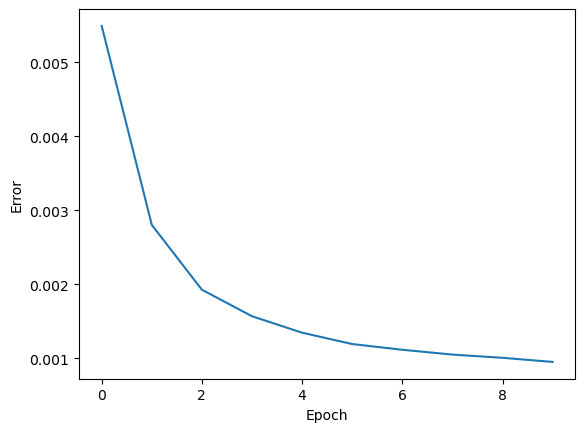

In [51]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [52]:
# select a user: mock_user_id = 143
mock_user_id = 143

In [53]:
# Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [54]:
# Feeding in the user and reconstructing the input. use sigmoid
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

### get the scores and recommendations

In [55]:
scored_asin_df_mock = cleaned.drop_duplicates(subset=['ProductId'])
scored_asin_df_mock = scored_asin_df_mock.assign(RecommendationScore = rec[0])
scored_asin_df_mock[['ProductId','RecommendationScore']].sort_values(["RecommendationScore"], ascending=False).head(20)

,ProductId,RecommendationScore
11445,B001EQ4G54,0.045425
11792,B004P4TL8E,0.027483
72,B006SQBRMA,0.024515
74,B001EPPI84,0.012050
6322,B000084EKW,0.011641
1943,B005ATI9EU,0.006303
8111,B005QKH18I,0.006219
19825,B003EZ1R46,0.005067
5622,B001I8BONA,0.004892
6422,B000OIT8T2,0.004527


We're going to use the mock userID which was 143 to see what other items he will be interested in.

In [56]:
book_df_mock = cleaned[cleaned['UserID'] == 143]
book_df_mock.head()

,ProductId,ProfileName,Score,Text,HelpfulnessNumerator,HelpfulnessDenominator,Percent,Polarity_Rating,UserID
143,B001GVISJW,c2,5,If you are looking for a less messy version of...,0,0,0.0,Positive,143
3587,B004X8TK9W,c2,5,I may be dating myself here a bit but I rememb...,1,1,100.0,Positive,143
4993,B000FA398U,c2,5,Try these first for all your seafood soups and...,3,3,100.0,Positive,143
6371,B000084EKO,c2,3,I honestly cannot say that I saw any differenc...,0,0,0.0,Negative,143
6372,B000084EKA,c2,4,I think 9 Lives does a better job on this vari...,0,0,0.0,Positive,143


In [78]:
#Merging book_df_mock with scored_asin_df_mock by ProductID
merged_df_mock = scored_asin_df_mock.merge(book_df_mock, on='ProductId', how='outer')

In [79]:
merged_df_mock[['ProductId','RecommendationScore']].sort_values(["RecommendationScore"], ascending=False).head(5)

,ProductId,RecommendationScore
1623,B001EQ4G54,0.045425
1683,B004P4TL8E,0.027483
21,B006SQBRMA,0.024515
23,B001EPPI84,0.012050
1012,B000084EKW,0.011641


Above is the top 5 items that Chris will be interested in purchasing or review.

# Tunning Hyperparameters

In [59]:
import keras_tuner as kt 

# Delete any logs from a previous run

In [60]:
import os
import shutil

# shutil module is part of the Python standard library and provides a 
# collection of utility functions for working with files and directories. 

folder_path = "my_dir/intro_to_kt/"

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Remove the folder and its contents recursively
    shutil.rmtree(folder_path)
    print(f"The folder '{folder_path}' has been deleted.")
else:
    print(f"The folder '{folder_path}' does not exist.")

The folder 'my_dir/intro_to_kt/' has been deleted.


### Create a function with the model. 
#### Let's tune the neurons or units with values from 4 to 20 in multiple of 4

In [65]:
def model_builder(hp):
    # create model
    model = Sequential()
    
    hp_units = hp.Int('units', min_value=4, max_value=20, step=4)
    model.add(Dense(units=hp_units, input_dim=48, activation='relu'))
    
    ### add the final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

Instantiate the tuner and perform hypertuning

Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn. In this tutorial, we are using Hyperband tuner.

To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

factor
- the denominator of the number of models trained in every iteration of the training loop.
For example, if the tuner has trained 9 models in the first loop. 9 gets divided by 3, and it continues training 3 models for a few more epochs. After that, it divides the number of models again and picks 1 model for additional training.

EarlyStopping:
- Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

In [66]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy',
                     max_epochs=10, factor=3, 
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [67]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [68]:
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}.
""")

Trial 5 Complete [00h 00m 00s]
val_accuracy: 0.6024038195610046

Best val_accuracy So Far: 0.6024038195610046
Total elapsed time: 00h 00m 57s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 4.



### Train the model

Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [69]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Train on 8320 samples, validate on 2080 samples
Epoch 1/50
8320/8320 [==============================] - 0s 11us/sample - loss: 180.0586 - accuracy: 0.5471 - val_loss: 67.6955 - val_accuracy: 0.5760
Epoch 2/50
8320/8320 [==============================] - 0s 7us/sample - loss: 27.3670 - accuracy: 0.6012 - val_loss: 17.1855 - val_accuracy: 0.5928
Epoch 3/50
  32/8320 [..............................] - ETA: 0s - loss: 4.6092 - accuracy: 0.7188

2023-12-09 18:38:32.270575: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense_3/bias/v/Assign' id:688 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_3/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_3/bias/v, training_2/Adam/dense_3/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-09 18:38:32.358179: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:526 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the futu

8320/8320 [==============================] - 0s 7us/sample - loss: 7.5929 - accuracy: 0.6149 - val_loss: 6.3767 - val_accuracy: 0.6000
Epoch 4/50
8320/8320 [==============================] - 0s 7us/sample - loss: 2.9876 - accuracy: 0.6204 - val_loss: 3.0064 - val_accuracy: 0.6000
Epoch 5/50
8320/8320 [==============================] - 0s 7us/sample - loss: 1.6720 - accuracy: 0.6218 - val_loss: 1.7865 - val_accuracy: 0.6048
Epoch 6/50
8320/8320 [==============================] - 0s 7us/sample - loss: 1.2200 - accuracy: 0.6213 - val_loss: 1.3341 - val_accuracy: 0.6038
Epoch 7/50
8320/8320 [==============================] - 0s 7us/sample - loss: 1.0172 - accuracy: 0.6216 - val_loss: 1.1236 - val_accuracy: 0.6096
Epoch 8/50
8320/8320 [==============================] - 0s 7us/sample - loss: 0.9003 - accuracy: 0.6212 - val_loss: 0.9920 - val_accuracy: 0.6053
Epoch 9/50
8320/8320 [==============================] - 0s 7us/sample - loss: 0.8014 - accuracy: 0.6233 - val_loss: 0.9115 - val_accura

Re-instantiate the hypermodel and t|rain it with the optimal number of epochs from above.

In [70]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

Train on 8320 samples, validate on 2080 samples
Epoch 1/11
8320/8320 [==============================] - 0s 12us/sample - loss: 431.1956 - accuracy: 0.5395 - val_loss: 163.7834 - val_accuracy: 0.5288
Epoch 2/11
8320/8320 [==============================] - 0s 7us/sample - loss: 52.5240 - accuracy: 0.5828 - val_loss: 17.9146 - val_accuracy: 0.5798
Epoch 3/11
  32/8320 [..............................] - ETA: 0s - loss: 4.6159 - accuracy: 0.5312

2023-12-09 18:38:44.750240: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/dense_4/kernel/v/Assign' id:1006 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_4/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_4/kernel/v, training_4/Adam/dense_4/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-12-09 18:38:44.844733: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_2/mul' id:859 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in

8320/8320 [==============================] - 0s 8us/sample - loss: 7.8863 - accuracy: 0.6174 - val_loss: 6.2868 - val_accuracy: 0.6019
Epoch 4/11
8320/8320 [==============================] - 0s 7us/sample - loss: 3.0384 - accuracy: 0.6208 - val_loss: 3.3960 - val_accuracy: 0.6048
Epoch 5/11
8320/8320 [==============================] - 0s 7us/sample - loss: 1.8739 - accuracy: 0.6236 - val_loss: 2.3351 - val_accuracy: 0.6048
Epoch 6/11
8320/8320 [==============================] - 0s 7us/sample - loss: 1.3722 - accuracy: 0.6214 - val_loss: 1.7241 - val_accuracy: 0.6053
Epoch 7/11
8320/8320 [==============================] - 0s 7us/sample - loss: 1.0838 - accuracy: 0.6212 - val_loss: 1.3500 - val_accuracy: 0.6096
Epoch 8/11
8320/8320 [==============================] - 0s 7us/sample - loss: 0.8836 - accuracy: 0.6209 - val_loss: 1.1973 - val_accuracy: 0.6034
Epoch 9/11
8320/8320 [==============================] - 0s 7us/sample - loss: 0.7901 - accuracy: 0.6209 - val_loss: 1.0925 - val_accura

evaluate the hypermodel on the test data.

In [71]:
eval_result = hypermodel.evaluate(x_train, y_train)
print("[test loss, test accuracy]:", eval_result)

[test loss, test accuracy]: [0.7392454730547392, 0.6182692]


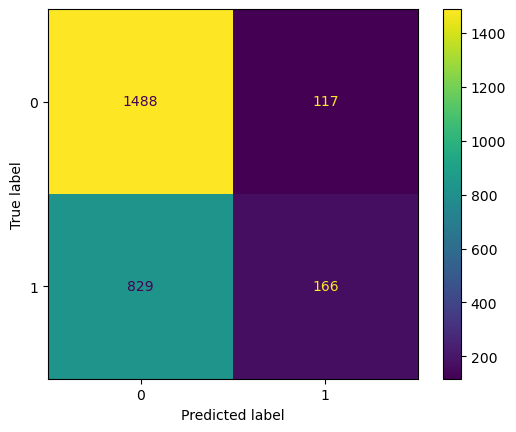

In [73]:
clf = SVC(random_state=0)
clf.fit(x_train, y_train)
SVC(random_state=0)
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test)

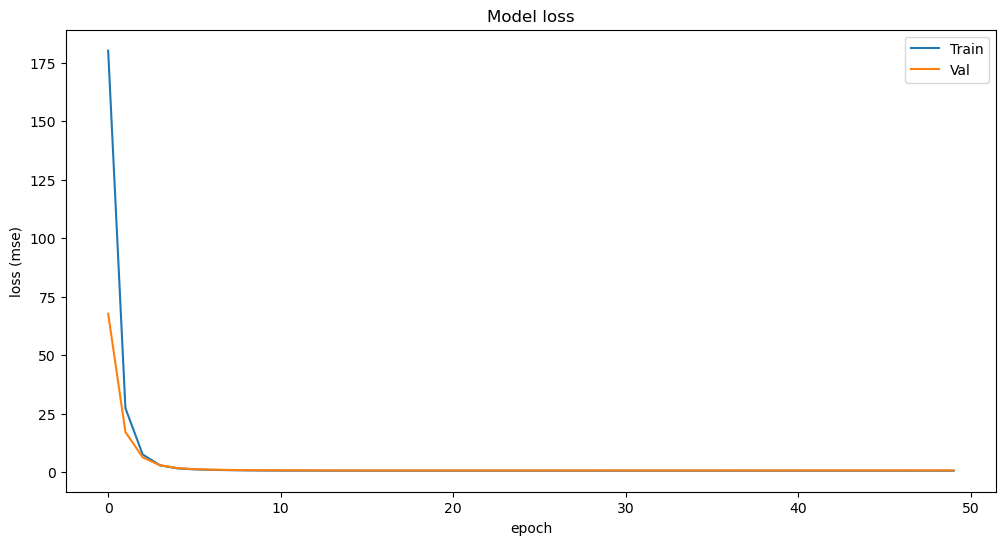

In [74]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (mse)')
plt.legend(['Train', 'Val'], loc='upper right')

In [75]:
from sklearn.metrics import mean_absolute_error

# Let's check how much we are off on average
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)

y_pred[0:5]

2023-12-09 18:38:56.176768: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_3/Sigmoid' id:469 op device:{requested: '', assigned: ''} def:{{{node dense_3/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


array([[0.3761968],
       [0.3761968],
       [0.3761968],
       [0.3761968],
       [0.3761968]], dtype=float32)

In [76]:
mae

0.4693741890389573

In [77]:
y_pred[42]

array([0.3761968], dtype=float32)

<h2> Conclusion and Summary</h2>

In this project we created a simple RNN model to determine where a review was positive or negative. We initial explored the data by plotting the total number or review by reviewer displaying the Top 10. We displayed the top 10 using a histogram, and added a Top 25. 

The RNN Model was able to recommend products for the user c2. According to the matrix the model predicted correctly 1488 the sentiment correctly of the reviews.